# 🧠 Predicting Alzheimer's Risk Using SNP-Based Synthetic Genotype Data and Machine Learning

This notebook simulates individual-level genotype data from ClinVar-filtered Alzheimer's SNPs, applies exploratory data analysis, and prepares the dataset for machine learning classification.


📁 SECTION 0: Mount Google Drive and Set Paths

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths (update if your folder is different)
clinvar_path = "/content/drive/MyDrive/variant_summary.txt"
cleaned_snp_output = "/content/drive/MyDrive/alzheimers_variants_cleaned.csv"
genotype_output = "/content/drive/MyDrive/synthetic_genotype_matrix.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**🧬 SECTION 1: Filter ClinVar for Alzheimer’s SNPs**

In [ ]:
import pandas as pd

# Load only required columns to save memory
df = pd.read_csv(clinvar_path, sep='\t', usecols=[
    "RS# (dbSNP)", "GeneSymbol", "PhenotypeList", "ClinicalSignificance"
], low_memory=False)

# Filter for Alzheimer's-related phenotypes
alz_df = df[df['PhenotypeList'].str.contains("Alzheimer", case=False, na=False)]

# Filter for strong classifications
alz_df = alz_df[alz_df['ClinicalSignificance'].isin([
    "Pathogenic", "Likely pathogenic", "Benign", "Likely benign"
])]

# Binary label: 1 for pathogenic, 0 for benign
alz_df['Label'] = alz_df['ClinicalSignificance'].apply(lambda x: 1 if "Pathogenic" in x else 0)

# Drop rows with missing SNPs
alz_df = alz_df[alz_df["RS# (dbSNP)"].notna()]

# Save cleaned data
alz_df.to_csv(cleaned_snp_output, index=False)
print("Alzheimer SNPs filtered and saved.")


✅ Alzheimer SNPs filtered and saved.


**🧪 SECTION 2: Simulate Genotype Matrix for 1000 Individuals**

In [ ]:
import numpy as np

# Load cleaned SNPs
snp_df = pd.read_csv(cleaned_snp_output)
unique_snps = snp_df["RS# (dbSNP)"].dropna().unique()
pathogenic_snps = snp_df[snp_df["Label"] == 1]["RS# (dbSNP)"].dropna().unique()

# Generate matrix
n_individuals = 1000
genotype_matrix = []

for _ in range(n_individuals):
    row = []
    for snp in unique_snps:
        probs = [0.3, 0.4, 0.3] if snp in pathogenic_snps else [0.6, 0.3, 0.1]
        row.append(np.random.choice([0, 1, 2], p=probs))
    genotype_matrix.append(row)

# Create DataFrame
columns = [f"SNP_{int(float(snp))}" for snp in unique_snps]
genotype_df = pd.DataFrame(genotype_matrix, columns=columns)




**🏷️ SECTION 3: Assign Risk**

In [ ]:
# Risk: ≥25 genotype-2 values among pathogenic SNPs
pathogenic_cols = [f"SNP_{int(float(snp))}" for snp in pathogenic_snps if f"SNP_{int(float(snp))}" in genotype_df.columns]
risk_score = genotype_df[pathogenic_cols].apply(lambda row: (row == 2).sum(), axis=1)

genotype_df["Label"] = (risk_score >= 25).astype(int)
genotype_df.to_csv(genotype_output, index=False)

print("Genotype matrix with risk labels saved.")
print(genotype_df["Label"].value_counts())


✅ Genotype matrix with risk labels saved.
Label
0    687
1    313
Name: count, dtype: int64


🧬 Risk Score Distribution and Labeling Strategy

We define an individual's Alzheimer's risk based on the number of homozygous pathogenic SNPs.  
If an individual has 25 or more such genotypes, they are labeled as "at risk" (Label = 1), else "non-risk" (Label = 0).  
The plot below shows how individuals are distributed based on their risk scores, and how the threshold divides the two groups.


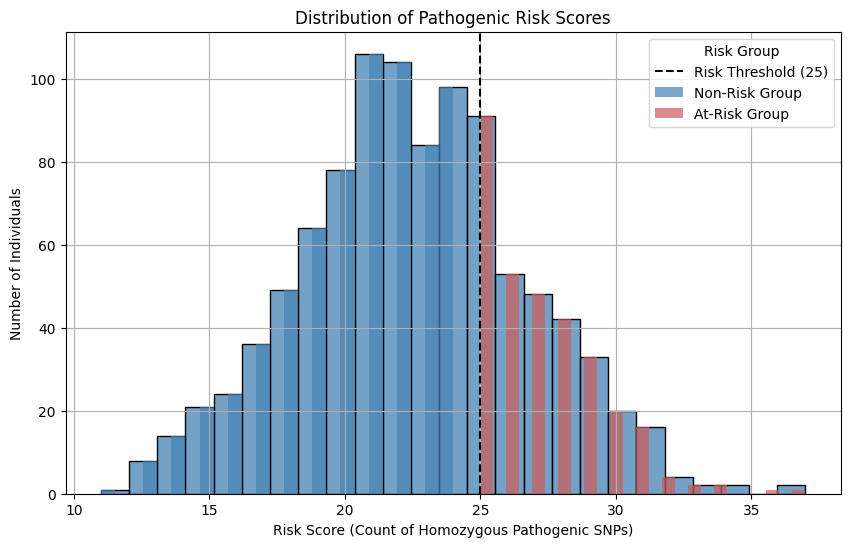

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of risk scores
plt.figure(figsize=(10, 6))
sns.histplot(risk_score, bins=25, kde=False, color='steelblue', edgecolor='black')

# Mark threshold
plt.axvline(x=25, color='black', linestyle='--', label='Risk Threshold (25)')

# Fill color below and above threshold
plt.hist(risk_score[risk_score < 25], bins=25, color='steelblue', alpha=0.7, label='Non-Risk Group')
plt.hist(risk_score[risk_score >= 25], bins=25, color='indianred', alpha=0.7, label='At-Risk Group')

plt.title('Distribution of Pathogenic Risk Scores')
plt.xlabel('Risk Score (Count of Homozygous Pathogenic SNPs)')
plt.ylabel('Number of Individuals')
plt.legend(title='Risk Group')
plt.grid(True)
plt.show()


📊 SECTION 4: Exploratory Data Analysis (EDA)

📊 4.1: Risk vs Non-Risk Bar Plot

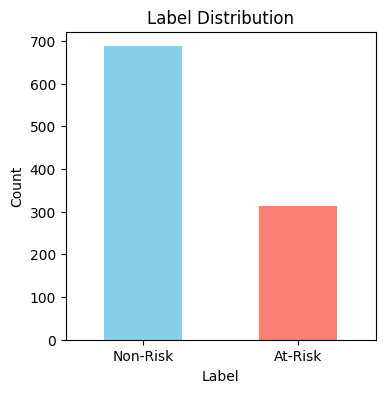

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of risk label distribution
plt.figure(figsize=(4, 4))
genotype_df["Label"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.xticks([0, 1], ["Non-Risk", "At-Risk"], rotation=0)
plt.title("Label Distribution")
plt.ylabel("Count")
plt.show()


📊 4.2: Genotype Distributions of Sample SNPs

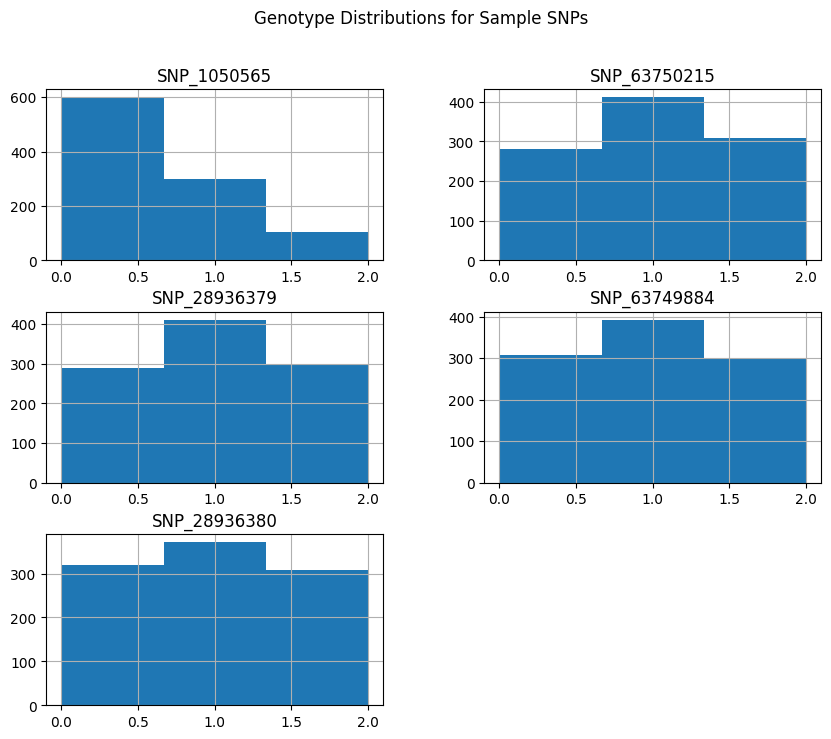

In [ ]:
# Plot genotype distributions for 5 random SNPs
sample_snps = genotype_df.columns[:5]  # or random.sample(list(columns), 5)
genotype_df[sample_snps].hist(figsize=(10, 8), bins=3)
plt.suptitle("Genotype Distributions for Sample SNPs")
plt.show()


📊 4.3: Melted Plot of Genotype Counts (0/1/2)

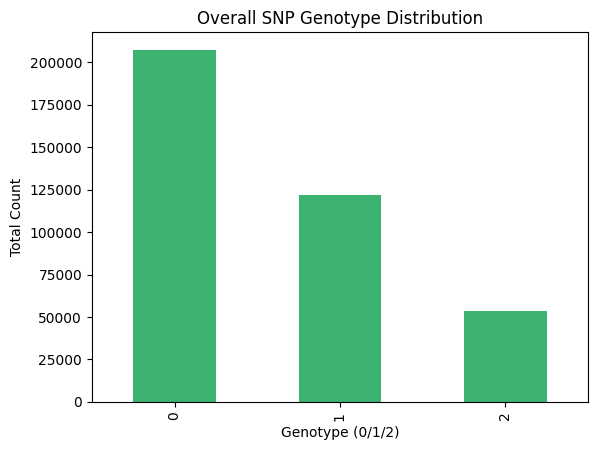

In [ ]:
# Melt all genotype data (excluding Label)
melted = genotype_df.drop(columns="Label").melt()

# Plot count of each genotype value
melted['value'].value_counts().sort_index().plot(kind='bar', color='mediumseagreen')
plt.title("Overall SNP Genotype Distribution")
plt.xlabel("Genotype (0/1/2)")
plt.ylabel("Total Count")
plt.show()


📊 4.4: Boxplots for SNPs vs Risk Label

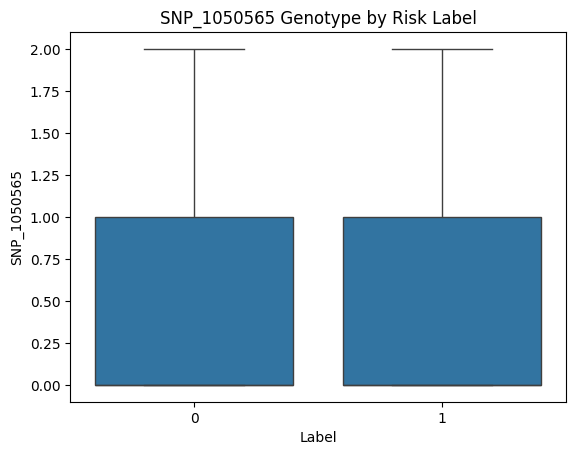

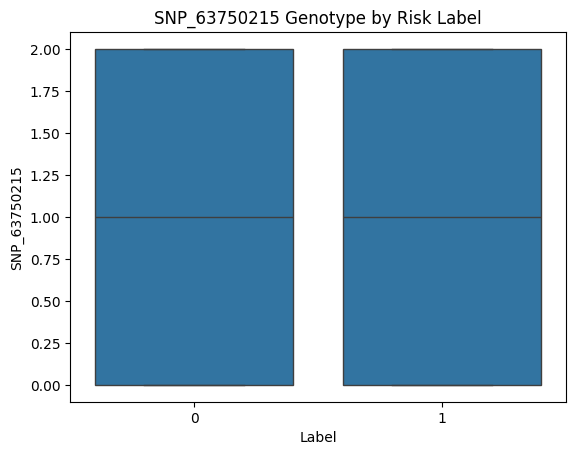

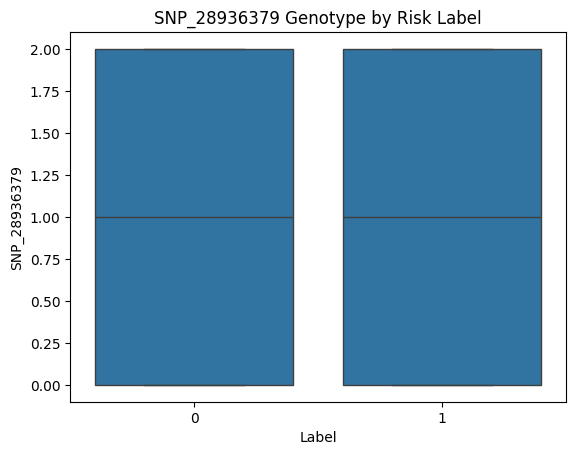

In [ ]:
# Boxplots for first 3 SNPs by risk group
for snp in genotype_df.columns[:3]:
    sns.boxplot(x="Label", y=snp, data=genotype_df)
    plt.title(f"{snp} Genotype by Risk Label")
    plt.show()


📊 4.5: PCA Visualization of Individuals

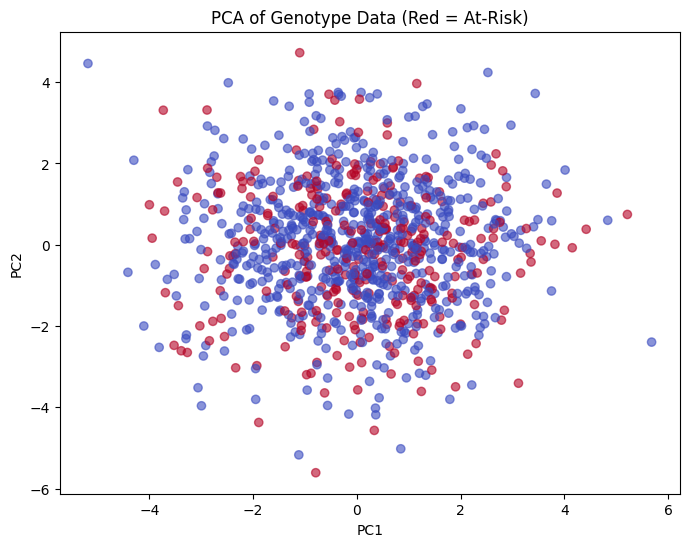

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_pca = genotype_df.drop(columns=["Label"])
y_pca = genotype_df["Label"]

# Standardize data
X_scaled = StandardScaler().fit_transform(X_pca)

# Run PCA
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_pca, cmap="coolwarm", alpha=0.6)
plt.title("PCA of Genotype Data (Red = At-Risk)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


🔄 SECTION 5: Prepare for Machine Learning

🧪 5.1: Train-Test Split


In [ ]:
from sklearn.model_selection import train_test_split

# Features (SNPs only), target (Label)
X = genotype_df.drop(columns=["Label"])
y = genotype_df["Label"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Summary
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Label distribution in training set:\n", y_train.value_counts(normalize=True))
print("\nLabel distribution in test set:\n", y_test.value_counts(normalize=True))



Train shape: (800, 383)
Test shape : (200, 383)
Label distribution in training set:
 Label
0    0.6875
1    0.3125
Name: proportion, dtype: float64

Label distribution in test set:
 Label
0    0.685
1    0.315
Name: proportion, dtype: float64


🧠 SECTION 6: Train Machine Learning Models
6.1: Logistic Regression
python

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = log_reg.predict(X_test)
y_probs_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression - Classification Report:\n")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


🔍 Logistic Regression - Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       137
           1       0.57      0.48      0.52        63

    accuracy                           0.72       200
   macro avg       0.67      0.65      0.66       200
weighted avg       0.71      0.72      0.71       200

Confusion Matrix:
 [[114  23]
 [ 33  30]]


6.2: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_probs_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest - Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


🌲 Random Forest - Classification Report:

              precision    recall  f1-score   support

           0       0.69      1.00      0.81       137
           1       0.00      0.00      0.00        63

    accuracy                           0.69       200
   macro avg       0.34      0.50      0.41       200
weighted avg       0.47      0.69      0.56       200

Confusion Matrix:
 [[137   0]
 [ 63   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Threshold verification


In [ ]:
thresholds = range(10, 31, 5)  # Try 10, 15, 20, 25, 30
results = []

for thresh in thresholds:
    # Recalculate risk score and label based on the current threshold
    risk_score = genotype_df[pathogenic_cols].apply(lambda row: (row == 2).sum(), axis=1)
    genotype_df['Label'] = (risk_score >= thresh).astype(int)

    X = genotype_df.drop('Label', axis=1)
    y = genotype_df['Label']

    # Check if both classes are present before splitting and training
    if y.nunique() < 2:
        print(f"Skipping threshold {thresh}: Only one class ({y.iloc[0]}) present in the data.")
        results.append((thresh, None, None)) # Append None for AUCs
        continue # Skip to the next threshold

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    lr = LogisticRegression(max_iter=1000, random_state=42) # Added random_state for reproducibility
    rf = RandomForestClassifier(n_estimators=100, random_state=42) # Added random_state for reproducibility

    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    y_probs_lr = lr.predict_proba(X_test)[:, 1]
    y_probs_rf = rf.predict_proba(X_test)[:, 1]

    auc_lr = roc_auc_score(y_test, y_probs_lr)
    auc_rf = roc_auc_score(y_test, y_probs_rf)

    results.append((thresh, auc_lr, auc_rf))

# Convert to DataFrame for easier viewing
auc_df = pd.DataFrame(results, columns=["Threshold", "AUC_LogReg", "AUC_RandomForest"])
print(auc_df)

Skipping threshold 10: Only one class (1) present in the data.
   Threshold  AUC_LogReg  AUC_RandomForest
0         10         NaN               NaN
1         15    0.688525          0.603142
2         20    0.796580          0.699169
3         25    0.812165          0.720930
4         30    0.756561          0.626474


📈 SECTION 7: Evaluate with ROC Curves

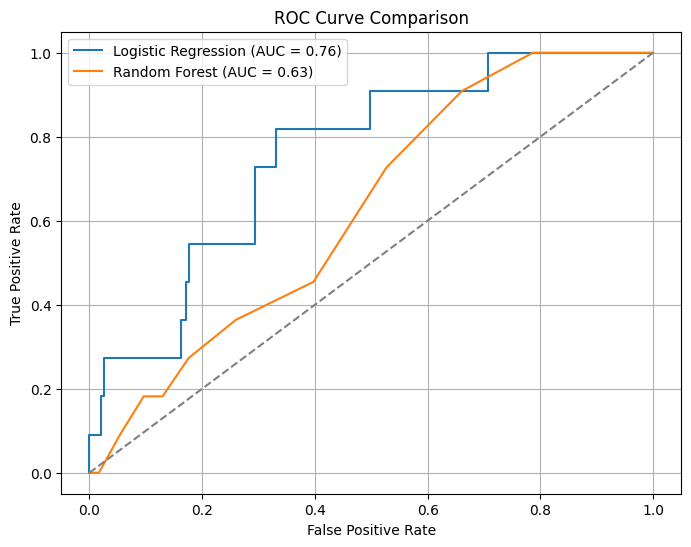

In [ ]:
# Plot ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_probs_lr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_probs_rf):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


#Precision Recall Curve

✅ Saved: precision_recall_curve.png


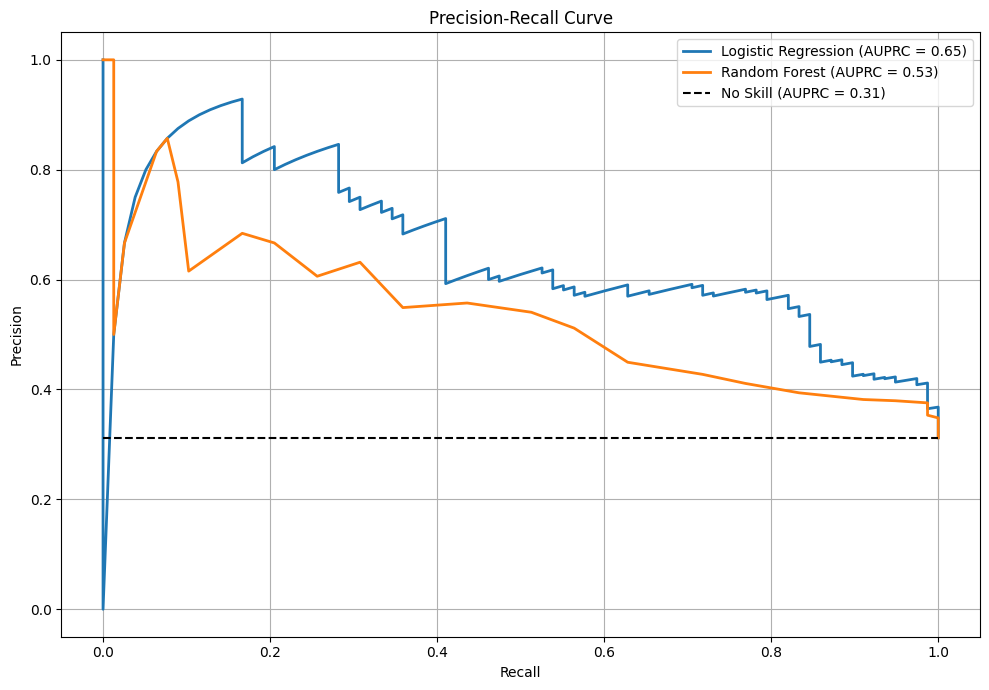

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Load labeled data only
genotype_df = pd.read_csv("/content/drive/MyDrive/synthetic_genotype_matrix.csv")
X = genotype_df.drop(columns=["Label"])
y = genotype_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

plt.figure(figsize=(10, 7))
for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    p, r, _ = precision_recall_curve(y_test, probs)
    plt.plot(r, p, lw=2, label=f"{name} (AUPRC = {average_precision_score(y_test, probs):.2f})")

plt.plot([0, 1], [y_test.mean()]*2, 'k--', label=f"No Skill (AUPRC = {y_test.mean():.2f})")
plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(); plt.tight_layout(); plt.savefig("precision_recall_curve.png")



🔍 SECTION 8: Feature Importance (Random Forest)

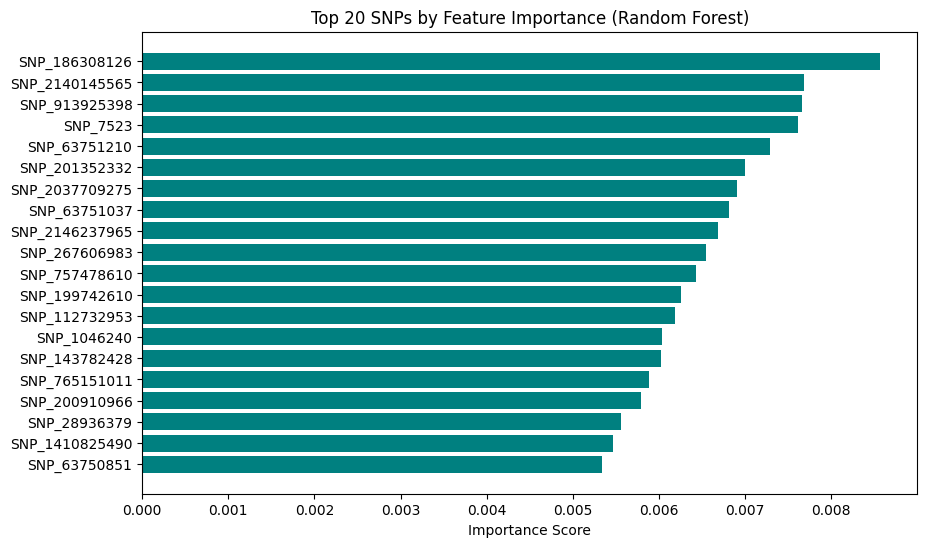

In [ ]:
# Get top features
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # top 20 features
top_snp_names = X.columns[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1], color='teal')
plt.yticks(range(20), top_snp_names[::-1])
plt.title("Top 20 SNPs by Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()


SECTION 9: SHAP (Explainable ML)


In [ ]:
# SHAP explanation (install once)
'''!pip install shap'''

import shap
import numpy as np

# SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Debug info
print("SHAP output type:", type(shap_values))
print("SHAP shape:", np.shape(shap_values))
print("X_test shape:", X_test.shape)


SHAP output type: <class 'numpy.ndarray'>
SHAP shape: (250, 383, 2)
X_test shape: (250, 383)


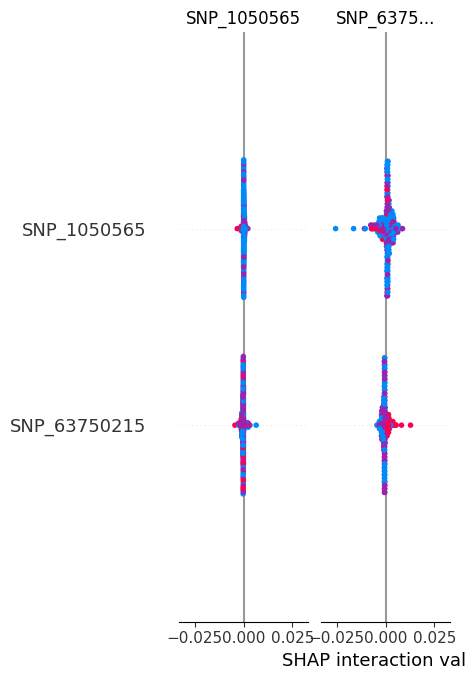

In [ ]:
# Safely handle binary classification vs multi-class
if isinstance(shap_values, list):
    print("Using class 1 SHAP values (positive class)")
    shap.summary_plot(shap_values[1], X_test, plot_size=(10, 10))  # Wider plot
else:
    shap.summary_plot(shap_values, X_test, plot_size=(10, 10))

